In [2]:
%matplotlib inline
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import IPython.display
import collections
from collections import Counter
import seaborn as sns
#import pyfluidsynth

from pathlib import Path
import pretty_midi
import librosa.display
import glob
import datetime

from music21 import *

import tensorflow as tf
tf.enable_eager_execution()

%load_ext autoreload
%autoreload 2

folder = 'train/'


In [3]:
# some prep steps
# for google colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
    
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive/')
    data_folder = "/content/drive/My Drive/Colab Notebooks/data/"
    os.chdir(data_folder)
else:
    data_folder = ""


# A. Preprocess Midi file
#### Choose a harmony and a melody track from a MIDI file

In [ ]:
def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

In [79]:
## PARAMS
# highest note is melody
LOW = 24 # E1=40, C2=48, C3=60, C4=72, C5=84, C6=96
HIGH = 60 # range(48,84) = 36 notes 

# input sizes
MELODY = 37 
TIMES = 48
CHORDS = 12


In [5]:
# krumhansl schmuckler
# adapted from https://gist.github.com/bmcfee/1f66825cef2eb34c839b42dddbad49fd
import scipy.linalg
import scipy.stats

def ks_key(X, weights='kessler'):
    '''Estimate the key from a pitch class distribution
    
    Parameters
    ----------
    X : np.ndarray, shape=(12,)
        Pitch-class energy distribution.  Need not be normalized
        
    Returns
    -------
    major : np.ndarray, shape=(12,)
    minor : np.ndarray, shape=(12,)
    
        For each key (C:maj, ..., B:maj) and (C:min, ..., B:min),
        the correlation score for `X` against that key.
    '''
    X = scipy.stats.zscore(X)
    
    # Coefficients from Kumhansl and Schmuckler
    # as reported here: http://rnhart.net/articles/key-finding/
    
    # weights as https://musicinformationretrieval.wordpress.com/2017/02/24/state-of-the-art-2/
    if weights == 'kessler':
        major = np.asarray([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
        minor = np.asarray([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17])
    elif weights == 'schmuckler':
        major = np.asarray([6.35, 2.33, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
        minor = np.asarray([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17])
    elif weights == 'aarden':
        major = np.asarray([17.7661, 0.145624, 14.9265, 0.160186, 19.8049, 11.3587, 0.281248, 22.062, 0.145624, 8.15494, 0.232998, 4.95122])
        minor = np.asarray([18.2648, 0.737619, 14.0499, 16.8599, 0.702494, 14.4362, 0.702494, 18.6161, 4.56621, 1.93186, 7.37619, 1.75623])
    elif weights == 'sapp':
        major = np.asarray([2, 0, 1, 0, 1, 1, 0, 2, 0, 1, 0, 1])
        minor = np.asarray([2, 0, 1, 1, 0, 1, 0, 2, 1, 0, 0.5, 0.5])
    elif weights == 'bellman':
        major = np.asarray([16.8, 0.86, 12.95, 1.41, 13.49, 11.93, 1.25, 20.28, 1.8, 8.04, 0.62, 10.57])
        minor = np.asarray([18.16, 0.69, 12.99, 13.34, 1.07, 11.15, 1.38, 21.07, 7.49, 1.53, 0.92, 10.21])
    elif weights == 'temperley':
        major = np.asarray([0.748, 0.06, 0.488, 0.082, 0.67, 0.46, 0.096, 0.715, 0.104, 0.366, 0.057, 0.4])
        minor = np.asarray([0.712, 0.84, 0.474, 0.618, 0.049, 0.46, 0.105, 0.747, 0.404, 0.067, 0.133, 0.33])
        
        
    major = scipy.stats.zscore(major)
    minor = scipy.stats.zscore(minor)
    
    # Generate all rotations of major
    major = scipy.linalg.circulant(major)
    minor = scipy.linalg.circulant(minor)
    
    major = major.T.dot(X)
    minor = minor.T.dot(X)
    
    major_max = np.argmax(major)
    minor_max = np.argmax(minor)
    return major_max if np.max(major) >= np.max(minor) else minor_max+12

In [35]:
#findings:
#len(pm.instruments) > 1 of files[:100] is 89
#bass and piano == 1 in files[:200] is 19
#bass==1 and piano >= 1 in files[:200] is 27

folder = "datasets/lmd_full/0/"
files = [file for file in os.listdir(folder) if '.mid' in file]
li = []
for file in files:
    try:
        pm = pretty_midi.PrettyMIDI(folder+file)
        if len(pm.instruments) > 1:
            pianos = 0
            melodies = 0
            for i, elt in enumerate(pm.instruments):
                if pm.instruments[i].is_drum:
                    continue
                if 'piano' in pm.instruments[i].name.lower():
                    pianos += 1
                if 'bass' in pm.instruments[i].name.lower():
                    melodies += 1
            if pianos == 1 and melodies == 1:
                li.append(file)
    except:
        pass
len(li)

873

In [36]:
#np.save('li.npy',li)

In [37]:
list(np.load('li.npy'))

['0891bfcac9993d3b22dc1f7c01b80f1f.mid',
 '027e89cd6a0e5adaacbb214a1c7d3289.mid',
 '000c856455f06e47924c6948966163db.mid',
 '0529418838c087204b92200108837531.mid',
 '025fb4d42ff236cb25881dde5c380c1a.mid',
 '01e3a3c73ed3718b355c291b791d6bd8.mid',
 '07cf2cd28a2e308e95b14ce81cf61393.mid',
 '0c82190c360989ab0556876fa0cd3b7a.mid',
 '01a42d89a3d51bb062071661f0681c9f.mid',
 '0ea7ef7aebf7873ef660bce626c11f3e.mid',
 '0b92a2c70d463826a7b3f7a3c8edde08.mid',
 '0a0ebf76d6c592b1092f0e0099787944.mid',
 '03bf318134fa092d3322c6e102999416.mid',
 '094e2ef35809908ee6b72adae7df2430.mid',
 '0eb64f80ca5e854a126fbe8a0f395712.mid',
 '0b45ed11371ab52f80b99fdd563183c9.mid',
 '0d6baeba14402f61c1ae2e625e1dd733.mid',
 '0e5fd4b2120dc668929bd9c8c927d82f.mid',
 '04d3680ee43321672d62492a45d573af.mid',
 '05129eaf807420f0361609d8196f2dba.mid',
 '02204b250990565789ea8620ff88fe6d.mid',
 '03429dae6c7ed3e77966e8bab1d13cbb.mid',
 '0592114bd24c23dd4de011003f3ce424.mid',
 '0e3939356abbdf05d4e852b3b8ff074c.mid',
 '0f10525e1249c3

In [132]:
# MIDI processing
def getMelodyAndHarmonyBass(file):
    #already midi file with one piano and one melody
    pm = pretty_midi.PrettyMIDI(file)
    pm.remove_invalid_notes()
    for i, elt in enumerate(pm.instruments):
        if 'piano' in pm.instruments[i].name.lower():
            piano = pm.instruments[i].notes
        elif 'bass' in pm.instruments[i].name.lower():
            bass = pm.instruments[i].notes
        try:
            result = {'melody': bass, 'harmony': piano}
        except:
            print(file)
    return result


def getMelodyAndHarmony(file):
    def padAndAdd(a,b):
        return sorted(a+b,key= lambda x:x.start)
    
    pm = pretty_midi.PrettyMIDI(file)
    pm.remove_invalid_notes()
    print("\nEasy Processing: "+file)
    
    if len(pm.instruments) == 1:
        print("Both: Using only track for both harmony and melody")
        pianoroll = pm.instruments[0].notes
        return {'melody': pianoroll, 'harmony': pianoroll}
    
    else:
        maxlen = 0
        pianos = []
        guitars = []
        melodies = []
        for i, elt in enumerate(pm.instruments):
            #if pm.instruments[i].is_drum:
            #    continue
            pianoroll = pm.instruments[i].get_piano_roll().T
            numnotes = pianoroll.nonzero()[0].shape[0]
            if numnotes > maxlen:
                mostnotes = i
                maxlen = numnotes
            if 'piano' in pm.instruments[i].name.lower():             #if pm.instruments[i].program in range(8): # MIDI 0..7 are pianos
                pianos.append((pm.instruments[i].notes,numnotes))
            if 'guitar' in pm.instruments[i].name.lower():             #if pm.instruments[i].program in range(24,32):
                guitars.append((pm.instruments[i].notes,numnotes))
            if 'melody' in pm.instruments[i].name.lower():
                # melodies.append((pianoroll,numnotes)) do i really want to padandadd two melodies always??
                melodies.append(pm.instruments[i].notes)

        if pianos != []:
            print("Harmony: Using piano with most notes as harmony of", len(pianos))
            pianowithmostnotes = max(pianos, key=lambda x: x[1])
            harmonytrack = pianowithmostnotes[0]
        elif guitars != []:
            print("Harmony: Using guitar with most notes as harmony of", len(guitars))
            guitarwithmostnotes = max(guitars, key=lambda x: x[1])
            harmonytrack = guitarwithmostnotes[0]
        else:
            print("Error: no piano or guitar track found")
            harmonytrack = pm.instruments[0].notes
            return

        if len(melodies) == 1:
            print("Melody: using only melody track as melody")
            melodytrack = melodies[0]
        elif len(melodies) == 2:
            print("Melody: padding and adding two melodies to one")
            melodytrack = padAndAdd(melodies[0], melodies[1])
        elif len(melodies) > 2:
            print("Melody: more than 2 melody tracks. padding and adding first two of # ", len(melodies),"melodies.")
            melodytrack = padAndAdd(melodies[0], melodies[1])
        else:
            print("Error: no melody track found.")
            melodytrack = pm.instruments[0].notes
            return

        return {'melody': melodytrack, 'harmony': harmonytrack}

def oneHot(idx, arraysize):
    if idx >= arraysize:
        print("error idx > arraysize")
        return
    ar = np.zeros(arraysize)
    ar[idx] = 1
    return ar

def processMidi(file):
    pm = pretty_midi.PrettyMIDI(file)
    #tracks = getMelodyAndHarmony(file)
    tracks = getMelodyAndHarmonyBass(file)

    pmnotes = tracks['melody']
    notes, times = [], []
    currenttime = 0
    for i, note in enumerate(pmnotes):
        if note.start > currenttime:
            notes.append(MELODY-1)
            duration = pm.time_to_tick(note.start-currenttime)
            times.append(duration)
        if note.pitch in range(LOW,HIGH):
            notes.append(note.pitch - LOW)
        else:
            notes.append(note.pitch % 12)
        if i < len(pmnotes)-1 and note.end > pmnotes[i+1].start: # overlap with next note
            times.append(pm.time_to_tick(pmnotes[i+1].start - note.start))
            currenttime = pmnotes[i+1].start
        else:
            times.append(pm.time_to_tick(note.end-note.start))
            currenttime = note.end
    times = np.array(np.round(np.array(times)/pm.resolution*12),dtype=np.int32)
    
    # getChords
    pmnotes = tracks['harmony']
    notesDict = {}
    for i, note in enumerate(pmnotes):
        end = note.end
        startbeat = int(pm.time_to_tick(note.start)/pm.resolution)
        endbeat = int(pm.time_to_tick(note.end)/pm.resolution)
        for j in range(startbeat, endbeat): #evry beat
            notesDict[j] = notesDict.get(j,np.zeros(12)) + oneHot(note.pitch % 12,12)
    

    # append for every beat (timestep) a vector. either np.zeros or chordinfovector
    chords = []
    for i in range(max(notesDict)): 
        chords.append(notesDict.get(i,np.zeros(12)))
    chordsByBeat = np.array(chords)
    

    # connect notes and chords
    currbeat = 0
    newchords = []
    for time in times:
        beat = int(currbeat/12)
        newchord = np.zeros(12)
        for j in range(int((time)/12)): 
            if j+beat < chordsByBeat.shape[0]:
                newchord += chordsByBeat[j+beat]
        newchords.append(newchord)
        currbeat += time
    chords = np.array(newchords)
    
    
     #cleanup
    times[np.where(times > 48)[0]] = 48
    notes = np.array(notes)[np.where(times > 0)[0]]
    chords = chords[np.where(times > 0)[0]]
    times = times[np.where(times > 0)[0]]
    times = times - 1 # reshift to 0..47
    
    
    #new Chord and key analysis, first only key analysis
    algkey = ks_key(pm.get_pitch_class_histogram(), 'aarden')
    key = oneHot(algkey,24)
    
    
    
    
    return notes, times, chords, chordsByBeat, key

In [148]:
# Input representation
def getCircleOfThirds(note):
    """input: note, scalar in [0,C)
    output: array, size (11,) including 3 bits for octave, 1 for rest
    """
    circleMajor = lambda x: x%4
    circleMinor = lambda x: x%3
    representation = np.zeros(11)
    if note < MELODY-1:
        absnote = note % 12
        octave = int(note/12)
        representation[7+octave] = 1
        representation[circleMajor(absnote)] = 1
        representation[4+circleMinor(absnote)] = 1
    else:
        representation[-1] = 1
    return representation

def getDuration(duration):
    """input size (1,) in [0,48)
       output size (6,)
    """
    return np.unpackbits(np.uint8(duration))[2:]

def getChord(chord):
    """input size (12,)
    outputs current and next chord shape (7,)
    """
    repre = np.zeros(7)
    for i, elt in enumerate(chord):
        x = elt * getCircleOfThirds(i)[:7]
        repre += x
    return repre

def getFeatureVectors(processedMidi, modulation=False): #TODO modulation ueberdenken
    """input size [7(pitch)+2(octaves)+1(Rest)]+6(duration)+7(chords)+7(nextchords)=30=Fsize #TODO: maybe change chords
    Creates Feature Vector from notes lists.
    Input: notes, times, chords from processMIDI
    Output: features array, size: (N, Fsize)  Fsize varies
    """
    notes, times, chords, chordsByBeat, key = processedMidi
    features = []
    for i, note in enumerate(notes[:-1]):
        feature = np.empty(0)
        if encodingDict['melody']:
            if notes[i] < MELODY: # pitch or pause bit
                feature = np.concatenate((feature, oneHot(notes[i],MELODY)))
            else:
                print("melody over 37")
                feature = np.concatenate((feature, np.zeros(MELODY)))
            
        if encodingDict['melodyModulo']: 
            if notes[i] < MELODY-1: # only pitch bit or zeros if pause
                feature = np.concatenate((feature, oneHot(notes[i]%12,12)))
            else:
                feature = np.concatenate((feature, np.zeros(12)))
        if encodingDict['melodyEncoded']: # pitch+octave+rest
            feature = np.concatenate((feature,getCircleOfThirds(note)))
        if encodingDict['duration']:
            feature = np.concatenate((feature,oneHot(int(times[i]),48)))  
        if encodingDict['durationEncoded']:
            feature = np.concatenate((feature,getDuration(times[i])))
        if encodingDict['chordsNormally']:
            feature = np.concatenate((feature,chords[i]))
            feature = np.concatenate((feature,chords[i+1]))
        if encodingDict['chordsEncoded']:
            feature = np.concatenate((feature,getChord(chords[i])))  # chord ERROR: MAKE THIS BETTER
            feature = np.concatenate((feature,getChord(chords[i+1])))   # chord ERROR: MAKE THIS BETTER
        if encodingDict['key']:
            feature = np.concatenate((feature,key))
        features.append(feature)
    features = np.array(features)
    return features.astype('float32')

def getInputSequences(processedMidi, padding=False, seq_len=16):
    """Create Net Input.
    Input: features from getFeatureVectors or getEncodedFeatureVectors
    Output: 
        - Sequences, size: (157, seq_len)
        - Labels, one-hot, size: (MELODY,)
    """
    features = getFeatureVectors(processedMidi)
    notes, times, _, _, _ = processedMidi
    sequences = []
    labels = []
    i = 0
    if padding == True:
        padded_notes = np.concatenate((np.zeros((seq_len,features.shape[1])),features[:seq_len]))
        for j in range(seq_len):
            sequences.append(padded_notes[j:j+seq_len])
            label_pitch = notes[j]
            label_duration = times[j]
            labels.append((label_pitch, label_duration))
    while i+seq_len < features.shape[0]:
        sequences.append(features[i:i+seq_len])
        label_pitch = notes[i+seq_len]
        label_duration = times[i+seq_len]
        labels.append((label_pitch, label_duration))
        i += 1     # or += seq_len
        
    sequences = np.array(sequences)
    labels = np.array(labels)
    return sequences, labels

def modulate(processedMidi, modulate=0):
    """modulates downwards"""
    notes, times, chords, chordsByBeat, key = processedMidi
    i = modulate
    modnotes = notes - i
    modnotes[np.where(modnotes == 36 - i)[0]] = 36
    modnotes[np.where(modnotes < 0)[0]] = 36

    modchords = np.append(chords[:,i:],chords[:,:i],axis=1)

    if chordsByBeat is not None:
        modcbb = np.append(chordsByBeat[:,i:],chordsByBeat[:,:i],axis=1)
    else:
        modcbb = None

    processedMidi = modnotes, times, modchords, chordsByBeat, key
    return processedMidi

In [40]:
# Choose encoding and load files
encodingDict = {
    'melody': True,
    'melodyModulo': True,
    'melodyEncoded': False,
    'duration': True,
    'durationEncoded': False,
    'chordsNormally': True,
    'chordsEncoded': False,
    'key': True
}

# B. Load Data

In [44]:
# gets all .mid filenames from folder train/ in one line
folder = "train/"
files = [file for file in os.listdir("train") if '.mid' in file]
folder = "datasets/lmd_full/0/"
files = li
files[:10]

['0891bfcac9993d3b22dc1f7c01b80f1f.mid',
 '027e89cd6a0e5adaacbb214a1c7d3289.mid',
 '000c856455f06e47924c6948966163db.mid',
 '0529418838c087204b92200108837531.mid',
 '025fb4d42ff236cb25881dde5c380c1a.mid',
 '01e3a3c73ed3718b355c291b791d6bd8.mid',
 '07cf2cd28a2e308e95b14ce81cf61393.mid',
 '0c82190c360989ab0556876fa0cd3b7a.mid',
 '01a42d89a3d51bb062071661f0681c9f.mid',
 '0ea7ef7aebf7873ef660bce626c11f3e.mid']

In [84]:
modulation = False

for i, file in enumerate(files[:10]):
    processedMidi = processMidi(folder+file)
    if modulation == True:
        for mod_i in range(12): # modulate
            processedMidi = modulate(processedMidi, modulate = mod_i)
            sequences, labels = getInputSequences(processedMidi, padding=False, seq_len=16)
            X = sequences if i==0 else np.concatenate((X, sequences))
            y = labels if i==0 else np.concatenate((y, labels))
    else:
        features = getFeatureVectors(processedMidi)
        sequences, labels = getInputSequences(processedMidi padding=False, seq_len=16)
        X = sequences if i==0 else np.concatenate((X, sequences))
        y = labels if i==0 else np.concatenate((y, labels))

X.shape, y.shape

((5835, 16, 145), (5835, 2))

In [110]:
def writeMidiSample(notes, times, file, originalfile, tempo=120, resolution=12):
    pm = pretty_midi.PrettyMIDI(resolution=resolution, initial_tempo=tempo)
    pminst = pretty_midi.Instrument(program=0)
    currtime = 0
    for i, note in enumerate(notes):
        if note != MELODY-1:
            pitch = note+LOW
            start = pm.tick_to_time(int(currtime))
            end = pm.tick_to_time(int(currtime+times[i]))
            if end > start:
                pmnote = pretty_midi.Note(velocity=100, pitch = pitch, start=start, end=end)
                pminst.notes.append(pmnote)
        currtime += times[i]+1
    pm.instruments.append(pminst)

    pm.write(file)
    return pm

[9, 7, 36, 7, 17, 36, 17, 36, 19, 36, 10, 9, 7, 36, 7, 36, 16]
[9, 7, 13, 7, 5, 12, 5, 14, 7, 16, 10, 9, 7, 14, 7, 12, 3]


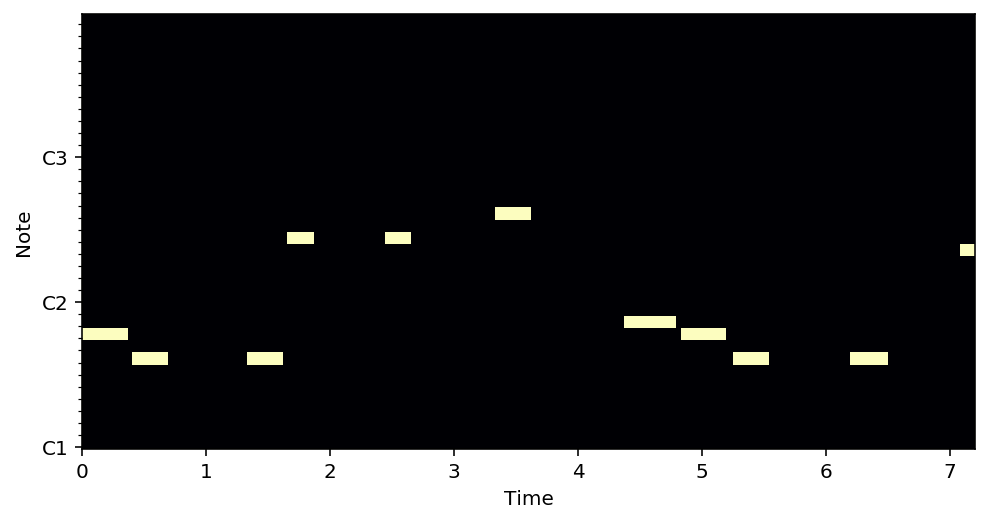

In [114]:
sample, samplelabel = X[100], y[100]


notes, times = [], []
for i in range(sample.shape[0]):
    notes.append(np.argmax(sample[i,:MELODY]))
    times.append(np.argmax(sample[i,MELODY:MELODY+TIMES]))
notes.append(samplelabel[0])
times.append(samplelabel[1])



#look at a sample
pm = writeMidiSample(notes, times, 'treval/lookatsample.mid', file)
plt.figure(figsize=(8, 4))
plot_piano_roll(pm, LOW, HIGH)
print(notes)
print(times)
display(IPython.display.Audio(pm.synthesize(fs=44000), rate=44000))   

In [13]:
#np.save('X.npy',X)
#np.save('y.npy',y)

# just load

In [8]:
X = np.load('X.npy')
y = np.load('y.npy')

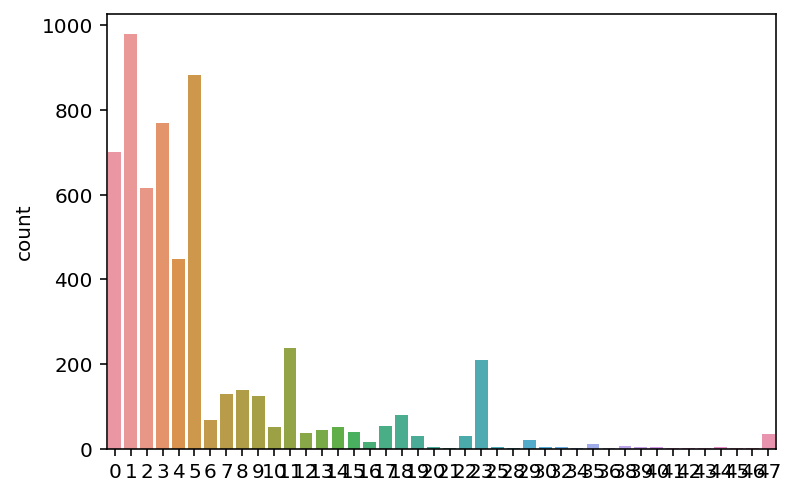

In [85]:
# stats of training data
pitches = y[:,0]
durations = y[:,1]
sns.countplot(durations)

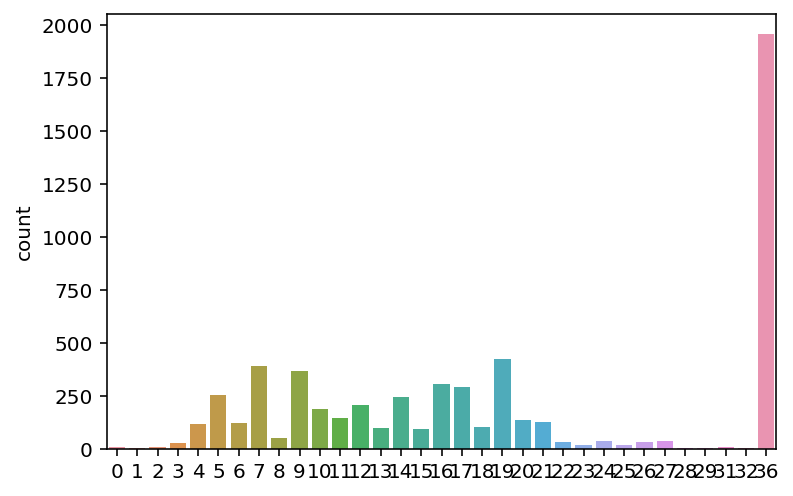

In [86]:
sns.countplot(pitches)

In [125]:
# train/val split
n = 70000
n = 2000
n = min(n,X.shape[0])
m = int(0.9*n)
data = X[:m]
labels = y[:m]
test_data = X[m:n]
test_labels = y[m:n]

perm = np.random.permutation(m)
p = int(0.9*m)

train_data = data[perm[:p]]
train_labels = labels[perm[:p]]
val_data = data[perm[p:]]
val_labels = labels[perm[p:]]

train_data.shape, train_labels.shape

((1620, 16, 145), (1620, 2))

### Load Data for Tensorflow

In [116]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
dataset = dataset.batch(batch_size, drop_remainder=True)
valdataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
valdataset = valdataset.batch(batch_size, drop_remainder=True)

In [117]:
# ToDo
# weighted randomsampler!
# batchnormalization

# C. Train a model

In [119]:
def build(input_dim, seq_len, hidden_dim, num_layers, output_dim_pitch, output_dim_duration):
    if tf.test.is_gpu_available():
        lstm = tf.keras.layers.CuDNNLSTM(hidden_dim, 
                                    return_sequences=True, 
                                    return_state=False, 
                                    recurrent_initializer='glorot_uniform')
        lastlstm = tf.keras.layers.CuDNNLSTM(hidden_dim, 
                                    return_sequences=False, 
                                    return_state=False, 
                                    recurrent_initializer='glorot_uniform')
    else:
        LSTM = tf.keras.layers.LSTM(hidden_dim, 
                               return_sequences=True, 
                               return_state=False, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')
        lastlstm = tf.keras.layers.LSTM(hidden_dim, 
                               return_sequences=False, 
                               return_state=False, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')
    
        
    inputs = tf.keras.Input(shape=(seq_len, input_dim))
    x = inputs
    for i in range(num_layers-1):
        x = LSTM(x)
    x = lastlstm(x)
    x = tf.keras.layers.Dropout(rate=0.3)(x)
    pitch = tf.keras.layers.Dense(output_dim_pitch, activation='softmax', name='pitch_out')(x)
    duration = tf.keras.layers.Dense(output_dim_duration, activation='softmax', name='duration_out')(x)

    model = tf.keras.Model(inputs=inputs, outputs=[pitch,duration])
    return model
    

In [126]:
# Build Model
model_params = {
    'input_dim': train_data.shape[-1],
    'seq_len': 16,
    'hidden_dim': 64,
    'num_layers': 2,
    'output_dim_pitch': MELODY,
    'output_dim_duration': TIMES,
}

model = build(**model_params)

In [99]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [103]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

In [127]:
model.compile(
    optimizer='adam',
    loss={'pitch_out': 'sparse_categorical_crossentropy', 
          'duration_out':'sparse_categorical_crossentropy'},
    metrics={'pitch_out': 'acc',
             'duration_out': 'acc'})

In [128]:
model.fit(train_data,[train_labels[:,0],train_labels[:,1]],batch_size=32,epochs=20)

Epoch 1/20
1620/1620 [==============================] - 3s 2ms/sample - loss: 5.7056 - pitch_out_loss: 2.7810 - duration_out_loss: 2.9246 - pitch_out_acc: 0.3315 - duration_out_acc: 0.1358
Epoch 2/20
1620/1620 [==============================] - 2s 1ms/sample - loss: 4.7713 - pitch_out_loss: 2.4254 - duration_out_loss: 2.3459 - pitch_out_acc: 0.3370 - duration_out_acc: 0.1667
Epoch 3/20
1620/1620 [==============================] - 2s 1ms/sample - loss: 4.6945 - pitch_out_loss: 2.3930 - duration_out_loss: 2.3015 - pitch_out_acc: 0.3488 - duration_out_acc: 0.1654
Epoch 4/20
1620/1620 [==============================] - 2s 1ms/sample - loss: 4.6328 - pitch_out_loss: 2.3330 - duration_out_loss: 2.2997 - pitch_out_acc: 0.3549 - duration_out_acc: 0.1574
Epoch 5/20
1620/1620 [==============================] - 2s 1ms/sample - loss: 4.4973 - pitch_out_loss: 2.2393 - duration_out_loss: 2.2581 - pitch_out_acc: 0.3500 - duration_out_acc: 0.1883
Epoch 6/20
1620/1620 [==============================] -

In [129]:
model.evaluate(val_data,[val_labels[:,0],val_labels[:,1]])

180/180 [==============================] - 1s 4ms/sample - loss: 3.1687 - pitch_out_loss: 1.3628 - duration_out_loss: 1.8059 - pitch_out_acc: 0.5944 - duration_out_acc: 0.3722


[3.1687456607818603, 1.3628428, 1.805903, 0.59444445, 0.37222221]

In [130]:
model.evaluate(test_data,[test_labels[:,0],test_labels[:,1]])

200/200 [==============================] - 0s 420us/sample - loss: 4.5566 - pitch_out_loss: 2.3585 - duration_out_loss: 2.1982 - pitch_out_acc: 0.2750 - duration_out_acc: 0.3850


[4.556626396179199, 2.3584676, 2.198159, 0.275, 0.385]

In [22]:
model.save('model.h5')

In [21]:
# old training routine
EPOCHS = 10
start = time.time()
hist = np.zeros(EPOCHS)

for epoch in range(EPOCHS):
    total_loss = 0
    pacc = 0
    correct, total, dcorrect, dtotal = 0,0,0,0 
    
    for (batch, (inputs, labels)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            batch_size = inputs.shape[0]
            model.hidden = model.init_hidden(batch_size)

            pitch, duration = model(inputs, True)

            loss_pitch = loss_fn(labels[:,0], pitch)
            loss_duration = loss_fn(labels[:,1], duration)

            batch_loss = loss_pitch + loss_duration
            
        total_loss += batch_loss
        

        #backprop
        gradients = tape.gradient(batch_loss, model.variables)
        optimizer.apply_gradients(zip(gradients, model.variables))
        
        #eval
        predicted = tf.argmax(pitch, 1)
        total += int(labels[:,0].shape[0])
        correct += sum(predicted.numpy()==labels[:,0].numpy())
        
        dpredicted = tf.argmax(duration, 1)
        dtotal += int(labels[:,1].shape[0])
        dcorrect += sum(dpredicted.numpy()==labels[:,1].numpy())
        
    hist[epoch] = total_loss
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    
    if epoch%2==0:
        notes = epoch%50==0
        acc_train = correct/total
        dacc_train = dcorrect/dtotal
        correct, total, dcorrect, dtotal = 0,0,0,0 
        
        # eval val set
        val_loss = 0
        for (batch, (inputs, labels)) in enumerate(valdataset):

            batch_size = inputs.shape[0]
            model.hidden = model.init_hidden(batch_size)

            pitch, duration = model(inputs, False)

            loss_pitch = loss_fn(labels[:,0], pitch)
            loss_duration = loss_fn(labels[:,1], duration)

            batch_loss = loss_pitch + loss_duration

            val_loss += batch_loss

            #eval
            predicted = tf.argmax(pitch, 1)
            total += int(labels[:,0].shape[0])
            correct += sum(predicted.numpy()==labels[:,0].numpy())

            dpredicted = tf.argmax(duration, 1)
            dtotal += int(labels[:,1].shape[0])
            dcorrect += sum(dpredicted.numpy()==labels[:,1].numpy())
        
        acc_val = correct/total
        dacc_val = dcorrect/dtotal
        
        print('Epoch: ',epoch,'/',EPOCHS,'in', np.round(time.time()-start,2),'s',\
              "loss: ", np.round(hist[epoch], 4), "acc_train: ", np.round(acc_train,2), "acc_val: ", np.round(acc_val,2))
        print("val_loss: ", np.round(val_loss, 4), "dacc_train: ", np.round(dacc_train,2), "dacc_val: ", np.round(dacc_val,2),'\n')#, \
        #"hacc_train: ", np.round(hacc_train,2), "hacc_val: ", np.round(hacc_val,2))

        if acc_train >= 90:
            print("finishing training at acc_train > 90")
            break
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

AttributeError: 'Model' object has no attribute 'init_hidden'

# Test Framework

## Test A: TradeFour

In [194]:
# read test midi file, ignore labels and get output from network
# simply read midi here to see how it sounds + plot (by creating midi file with input midi and prediction from network)

def writeMidi(notes, times, file, originalfile, tempo=120, resolution=12):
    pm = pretty_midi.PrettyMIDI(resolution=resolution, initial_tempo=tempo)
    pminst = pretty_midi.Instrument(program=0)
    currtime = 0
    for i, note in enumerate(notes):
        if note != MELODY-1:
            pitch = note+LOW
            start = pm.tick_to_time(int(currtime))
            end = pm.tick_to_time(int(currtime+times[i]))
            if end > start:
                pmnote = pretty_midi.Note(velocity=100, pitch = pitch, start=start, end=end)
                pminst.notes.append(pmnote)
        currtime += times[i]+1
    pm.instruments.append(pminst)
    
    #get original chords from file
    ogpm = pretty_midi.PrettyMIDI(originalfile)
    originalchords = pretty_midi.Instrument(program=0)
    originalnotes = getMelodyAndHarmonyBass(originalfile)['harmony']
    for i, note in enumerate(originalnotes):
        old = ogpm.time_to_tick(note.start)
        start = pm.tick_to_time(int(ogpm.time_to_tick(note.start)/ogpm.resolution*pm.resolution))
        end = pm.tick_to_time(int(ogpm.time_to_tick(note.end)/ogpm.resolution*pm.resolution))
        originalchords.notes.append(pretty_midi.Note(velocity=50, pitch=note.pitch, start=start, end=end))
    pm.instruments.append(originalchords)

    pm.write(file)
    return pm

    
def tradeFour(processedMidi):
    notes, times, chords, chordsByBeat, key = processedMidi
    predicted_notes, predicted_durations = [], []
    mel_len=16+1 # wegen nextChord

    notesnew = np.array(notes[-mel_len:])
    timesnew = np.array(times[-mel_len:])
    chordsnew = np.array(chords[-mel_len:])

    currentbeat = 0
    currenttime = 0
    while sum(predicted_durations) < 4*TIMES:
        processedMidi = notesnew, timesnew, chordsnew, chordsByBeat, key
        feat = getFeatureVectors(processedMidi)
        feat = tf.expand_dims(feat,0)
        
        pitch, duration = model(feat)

        pred_pitch = tf.math.argmax(pitch, 1).numpy()[0]
        pred_duration = tf.math.argmax(duration, 1).numpy()[0]

        predicted_notes.append(pred_pitch)
        predicted_durations.append(pred_duration)
        notesnew = np.append(notesnew[1:], pred_pitch)
        timesnew = np.append(timesnew[1:], pred_duration)
        
        if int(currenttime/12) > currentbeat:
            newchord = chordsByBeat[int(currenttime/12)]
            chordsnew = np.append(chordsnew[1:], newchord)
        currenttime += pred_duration
        currentbeat += int(currenttime/12)
        
        print(predicted_durations)
        
    notes = np.append(notes, np.array(predicted_notes))
    times = np.append(times, np.array(predicted_durations))

    return notes, times
    
def plotTradeFour(file):
    processedMidi = processMidi(file)
    
    t = time.time()
    notes, times = tradeFour(processedMidi)
    print(time.time() - t,'s')
    
    # plotWithAudio
    pm = writeMidi(notes, times, 'treval/newtest.mid', file)
    plt.figure(figsize=(8, 4))
    plot_piano_roll(pm, LOW, HIGH)
    display(IPython.display.Audio(pm.synthesize(fs=44000), rate=44000))   
    

In [195]:
li[9]

'0ea7ef7aebf7873ef660bce626c11f3e.mid'

test/testlmd.mid
[17]
[17, 1]
[17, 1, 2]
[17, 1, 2, 2]
[17, 1, 2, 2, 0]
[17, 1, 2, 2, 0, 0]
[17, 1, 2, 2, 0, 0, 2]
[17, 1, 2, 2, 0, 0, 2, 2]
[17, 1, 2, 2, 0, 0, 2, 2, 2]
[17, 1, 2, 2, 0, 0, 2, 2, 2, 2]
[17, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2]
[17, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 8]
[17, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 8, 8]
[17, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 8, 8, 7]
[17, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 8, 8, 7, 0]
[17, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 8, 8, 7, 0, 0]
[17, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 8, 8, 7, 0, 0, 1]
[17, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 8, 8, 7, 0, 0, 1, 1]
[17, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 8, 8, 7, 0, 0, 1, 1, 3]
[17, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 8, 8, 7, 0, 0, 1, 1, 3, 2]
[17, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 8, 8, 7, 0, 0, 1, 1, 3, 2, 1]
[17, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 8, 8, 7, 0, 0, 1, 1, 3, 2, 1, 2]
[17, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 8, 8, 7, 0, 0, 1, 1, 3, 2, 1, 2, 2]
[17, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 8, 8, 7, 0, 0, 1, 1, 3, 2, 1, 2, 2, 2]
[17, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 

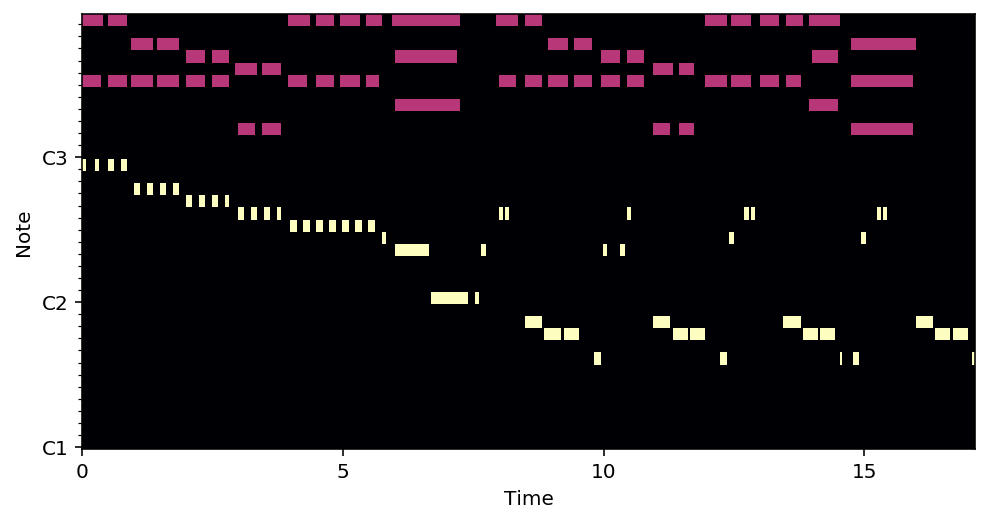

In [196]:
plotTradeFour('test/testlmd.mid')

## Test B: Overfitting

In [0]:
# test how much % model can learn a melody

# define test melody
# train network
# give percentage of how much it learnt

chordsDict={
    'C': [1,0,0,0,1,0,0,1,0,0,0,0],
    'C7': [1,0,0,0,1,0,0,1,0,0,1,0],
    'Cmaj7': [1,0,0,0,1,0,0,1,0,0,0,1]
}

In [0]:
# test data
notes = [0,2,4,7,7,4,2,0,0,2,4,7,7,4,2,0,0,5,3,4,5,8,7,5,0,2,4,7,7,4,2,0]
times = np.ones(32)*8
chord = chordsDict['C']
chords = np.repeat(chord, 32).reshape((12,-1)).T
encoding = True
train_data, train_labels = getInputSequences(notes, times, chords, encoding=encoding, modulation=False, padding=False, seq_len=1)

display(train_data.shape)
batch_size = 32
train_loader = getDataLoader(train_data, train_labels, batch_size=batch_size, shuffle=False)

# test model
model_params = {
    'input_dim': train_data.shape[-1],
    'hidden_dim': 64,
    'num_layers': 1,
    'output_dim_pitch': MELODY,
    'output_dim_duration': TIMES,
    'dropout': 0
}

testmodel = LSTM(**model_params)
testmodel.to(device)

(15, 16, 31)

Nr. of params: 30485


tensor([2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0])
tensor([0., 5., 3., 4., 5., 8., 7., 5., 0., 2., 4., 7., 7., 4., 2.],
       dtype=torch.float64)
loss:  7.3719 acc_train:  6 acc_val:  6
loss:  1.8806 acc_train:  20 acc_val:  20
loss:  1.8009 acc_train:  26 acc_val:  26
loss:  1.6949 acc_train:  33 acc_val:  33
loss:  1.5203 acc_train:  53 acc_val:  53
tensor([0, 5, 8, 4, 5, 8, 7, 5, 0, 7, 4, 7, 5, 4, 7])
tensor([0., 5., 3., 4., 5., 8., 7., 5., 0., 2., 4., 7., 7., 4., 2.],
       dtype=torch.float64)
loss:  1.2851 acc_train:  73 acc_val:  73
loss:  1.0255 acc_train:  80 acc_val:  80
loss:  0.8072 acc_train:  86 acc_val:  86
loss:  0.6302 acc_train:  86 acc_val:  86
loss:  0.4656 acc_train:  93 acc_val:  93
tensor([0, 5, 3, 4, 5, 8, 7, 5, 0, 2, 4, 7, 7, 4, 2])
tensor([0., 5., 3., 4., 5., 8., 7., 5., 0., 2., 4., 7., 7., 4., 2.],
       dtype=torch.float64)
loss:  0.3227 acc_train:  100 acc_val:  100
loss:  0.2176 acc_train:  100 acc_val:  100
loss:  0.1449 acc_train:  100 acc_val:  1

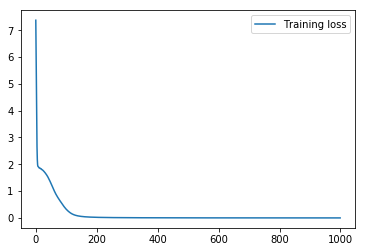

In [0]:
train_params = {
    'train_loader': train_loader,
    'val_loader': train_loader,
    'optim': torch.optim.Adam(testmodel.parameters(), lr=1e-2),
    'loss_fn': torch.nn.CrossEntropyLoss(),
    'num_epochs': 1000
}
train(testmodel, **train_params)

## Testing Krumhansl

In [0]:
folder = "datasets/lmd_full/0/"
#files[:5]

files = [file for file in os.listdir(folder) if '.mid' in file]
pm = pretty_midi.PrettyMIDI(folder + files[2])
pch = pm.get_pitch_class_histogram()

np.argmax(ks_key(pch)[1])

pm.key_signature_changes

folder = "datasets/Piano-midi.de/train/" #0.75 ohne C mit rel
folder = "datasets/kpcorpus/" 
folder = "datasets/lmd_full/2/"
t = time.time()

# find keys
files = [file for file in os.listdir(folder) if '.mid' in file]
    
def key(key_number):
    return pretty_midi.key_number_to_key_name(key_number)

def keynr(key):
    return pretty_midi.key_name_to_key_number(key)
       
def isFifth(realkey,predkey):
    return (realkey - predkey)%12 == 7 or (predkey - realkey)%12 == 7
        
def isRelative(realkey,predkey):
    if realkey > 11 and (realkey - 9) % 12 == predkey:
        return True
    elif predkey > 11 and (predkey - 9) % 12 == realkey:
        return True
    else:
        return False
        
def isParallel(realkey,predkey):
    return realkey%12 == predkey%12

correct ,fifth,relative,parallel,total = 0,0,0,0,0
keys=[]
print("Scale by first keychange event, \t Scale by KrumhanslSchmuckler, \t, Filename")
for i, file in enumerate(files[:100]):
    try:
        pm = pretty_midi.PrettyMIDI(folder + file)
    except:
        continue

    pm = pretty_midi.PrettyMIDI(folder + file)
    if pm.key_signature_changes != []:
        try:
            algkey = ks_key(pm.get_pitch_class_histogram(), 'aarden')
            pmkeys = [x.key_number for x in pm.key_signature_changes]
            pmkey = pmkeys[0]
            if pmkey == 0:
                continue
            keys.append([pmkey,algkey])
            #print(key(pmkey), '\t', key(int(algkey)), '\t', file, '\t', pmkeys)
        except:
            pass

correct ,fifth,relative,parallel,total = 0,0,0,0,0
for key in keys:
    realkey = key[0]
    predkey = key[1]
    total += 1
    if realkey == predkey:
        correct += 1
    elif isFifth(realkey,predkey):
        fifth += 1
    elif isRelative(realkey,predkey):
        relative += 1
    elif isParallel(realkey,predkey):
        parallel += 1
print("time", np.round(time.time()-t,2), "s")
print(correct, relative, fifth, parallel, total)
print((correct+relative)/total, correct/total, relative/total, fifth/total, parallel/total, (total-correct-fifth-relative-parallel)/total)


# Legacy

In [0]:
# smallest LSTM example
rnn = nn.LSTM(input_size=10, hidden_size=20, num_layers=2, batch_first=True) # It was batch_first=True!
inputs = torch.randn(5, 300, 10)
hidden = (torch.randn(2, 5, 20), torch.randn(2, 5, 20))
output, hidden = rnn(inputs, hidden)
output.shape

torch.Size([5, 300, 20])

In [0]:
def standardize(data):
    """ Move {0,1} data to {-1,1}, then standardize. Standardize data in [0,1]"""
    data = data.astype(np.float32)
    standardized_data = (data - np.mean(data, axis=0)[None,:,:]) / np.std(data, axis=0)[None,:,:]
    return standardized_data